In [1]:
# Module Import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.8.1  Device: cuda


In [3]:
BATCH_SIZE = 128
EPOCHS = 90

## Dataset Loading (STL10)

In [4]:
# loading training dataset
from torchvision import datasets
import torchvision.transforms as transforms
import os

# specify a data path
path2data = '../data'

# if not exists the path, make the path
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load STL10 train dataset, and check
data_transformer = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.STL10(path2data, split='train', download=True, transform=data_transformer)
print(train_dataset.data.shape)

Files already downloaded and verified
(5000, 3, 96, 96)


In [5]:
# load STL10 test dataset
test_dataset = datasets.STL10(path2data, split='test', download=True, transform=data_transformer)
print(test_dataset.data.shape)

Files already downloaded and verified
(8000, 3, 96, 96)


## Nomalization

In [6]:
meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [7]:
train_transformer = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(227),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
])

test_transformer = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
                transforms.Resize(227)
])

In [8]:
train_dataset.transform = train_transformer
test_dataset.transform = test_transformer

### Sample Data View

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1730
images indices:  1730


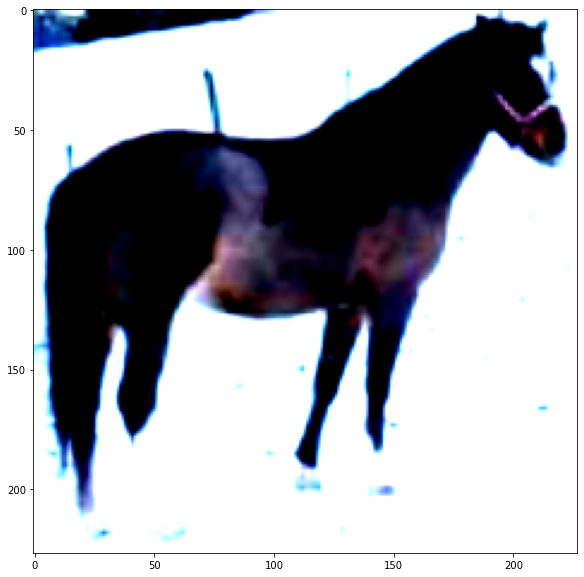

In [9]:
def show(img, y=None, color=True):

    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)
    
    # plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(y))

# pick a random sample image 
rnd_inds = int(np.random.randint(0, len(train_dataset), 1))
print(rnd_inds)
img, label = train_dataset[rnd_inds]
print('images indices: ', rnd_inds)

plt.figure(figsize=(10, 10))
show(img)

### Data Check

In [10]:
import collections
y_train = [y for _, y in train_dataset]
counter_train = collections.Counter(y_train)
print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit splits indices of test0 in same proportion of labels
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = list(range(len(test_dataset)))
y_test0 = [y for _,y in test_dataset]

for test_index, val_index in sss.split(indices, y_test0):
    print('test :', len(test_index) , 'val :', len(val_index))

test : 6400 val : 1600


In [12]:
from torch.utils.data import Subset

val_ds = Subset(test_dataset, val_index)
test_ds = Subset(test_dataset, test_index)

In [13]:
import collections
import numpy as np

y_test = [y for _, y in train_dataset]
y_val = [y for _, y in test_dataset]

counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)
print(counter_test)
print(counter_val)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})
Counter({6: 800, 7: 800, 5: 800, 0: 800, 3: 800, 1: 800, 4: 800, 9: 800, 2: 800, 8: 800})


### DataLoader

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Modeling Network

In [43]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [44]:
import torchvision.models as models

model = AlexNet().to(device)

In [45]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [46]:
from torchsummary import summary
summary(model, input_size=(3, 227, 227), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

## Training

In [47]:
optimizer = optim.SGD(
  params = model.parameters(),
  lr = 0.01,
  momentum = 0.9,
  weight_decay = 0.005  # lr 점점 감소
)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

loss_list = []
accuracy_list = []

for epoch in range(90):
    print('[epoch %d]' %epoch, end=' ')
    lr_scheduler.step()
    
    running_loss = 0.0
    correct = 0
    
    for imgs, classes in train_loader :
        
        imgs, classes = imgs.to(device), classes.to(device)
        
        optimizer.zero_grad()
        output = model(imgs)
        
        loss = F.cross_entropy(output, classes)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(classes.view_as(pred)).sum().item()
        
    cost = running_loss / len(train_loader)
    print('Train loss: %.3f | Train accuracy: %.2f%%' %(cost, 100.*correct/len(train_loader.dataset))) 
    loss_list.append(cost)
    accuracy_list.append(100.*correct/len(train_loader.dataset))

[epoch 0] Train loss: 2.302 | Train accuracy: 10.14%
[epoch 1] Train loss: 2.300 | Train accuracy: 9.98%
[epoch 2] Train loss: 2.290 | Train accuracy: 10.14%
[epoch 3] Train loss: 2.182 | Train accuracy: 16.16%
[epoch 4] Train loss: 1.972 | Train accuracy: 24.04%
[epoch 5] Train loss: 1.794 | Train accuracy: 27.98%
[epoch 6] Train loss: 2.111 | Train accuracy: 19.28%
[epoch 7] Train loss: 1.835 | Train accuracy: 25.92%
[epoch 8] Train loss: 1.775 | Train accuracy: 28.52%
[epoch 9] Train loss: 1.777 | Train accuracy: 28.84%
[epoch 10] Train loss: 1.659 | Train accuracy: 33.68%
[epoch 11] Train loss: 1.653 | Train accuracy: 34.24%
[epoch 12] Train loss: 1.625 | Train accuracy: 35.42%
[epoch 13] Train loss: 1.600 | Train accuracy: 36.90%
[epoch 14] Train loss: 1.613 | Train accuracy: 36.58%
[epoch 15] Train loss: 1.603 | Train accuracy: 38.36%
[epoch 16] Train loss: 1.486 | Train accuracy: 40.78%
[epoch 17] Train loss: 1.448 | Train accuracy: 42.96%
[epoch 18] Train loss: 1.470 | Train ac

In [48]:
correct = 0
total = 0
for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the test images: 63.76 %


In [49]:
x = np.arange(len(loss_list))

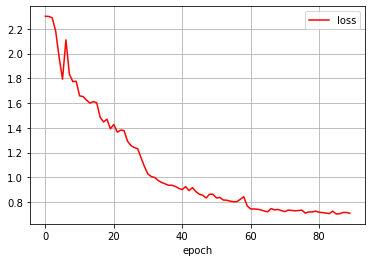

In [55]:
plt.plot(x, loss_list, c='red', label="loss")
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.show()

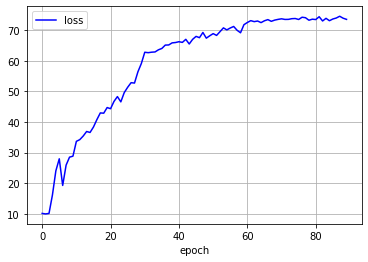

In [56]:
plt.plot(x, accuracy_list, c='blue', label="loss")
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.show()